In [6]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

nsepy's get_history() function seems to have some problem, it keeps on running without giving any output or just an empty dataframe as an output.
Luckily though, using get_price_list()  first seems to establish connection with the nse website and then get_history() works fine.

In [7]:
def preprocess(df):
    
    # create the target by shifting close price
    df["target"] = df.close.shift(-1)

    # update the last two target value
    last_value = df['target'].iloc[-2]
    df.at[df.index[-1], 'target'] = last_value
    return df

def add_technical(df):
    df['EMA_9'] = df['close'].ewm(9).mean().shift()
    df['SMA_5'] = df['close'].rolling(5).mean().shift()
    df['SMA_10'] = df['close'].rolling(10).mean().shift()
    df['SMA_15'] = df['close'].rolling(15).mean().shift()
    df['SMA_30'] = df['close'].rolling(30).mean().shift()
    EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
    def relative_strength_idx(df, n=14):
        close = df['close']
        delta = close.diff()
        delta = delta[1:]
        pricesUp = delta.copy()
        pricesDown = delta.copy()
        pricesUp[pricesUp < 0] = 0
        pricesDown[pricesDown > 0] = 0
        rollUp = pricesUp.rolling(n).mean()
        rollDown = pricesDown.abs().rolling(n).mean()
        rs = rollUp / rollDown
        rsi = 100.0 - (100.0 / (1.0 + rs))
        return rsi

    df['RSI'] = relative_strength_idx(df).fillna(0)
    EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
    df['MACD'] = pd.Series(EMA_12 - EMA_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    return df

# Train test split

In [8]:
def write_pred_actual_csv(df):
    filename = f"./output/pred-actual/xg-boost.csv"
    df.to_csv(filename)

def write_visual_csv(i, loss):
    filename = "./visual/data.csv"
    row_formatted = f"{(i + 1) // 2 + 1},xgboost,{'nltk' if i % 2 else 'bert'},{loss:.4f}"
    row = row_formatted.split(",")

    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

Best params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'random_state': 42, 'subsample': 0.8}
Best validation score = -0.458044199109939
0.5037275540632027


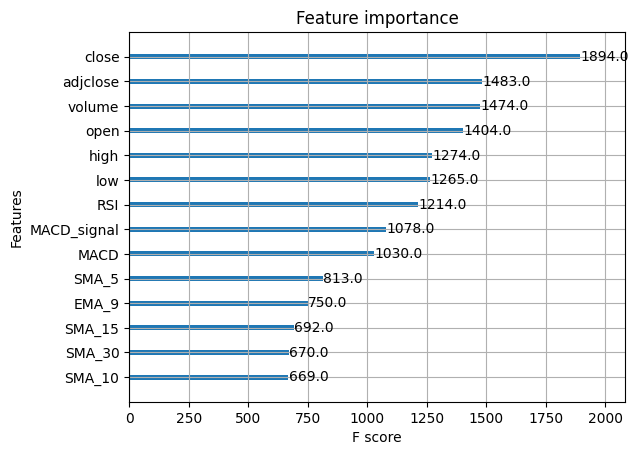

Best params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'random_state': 42, 'subsample': 0.8}
Best validation score = -0.45964397490677183
0.4895499908655434


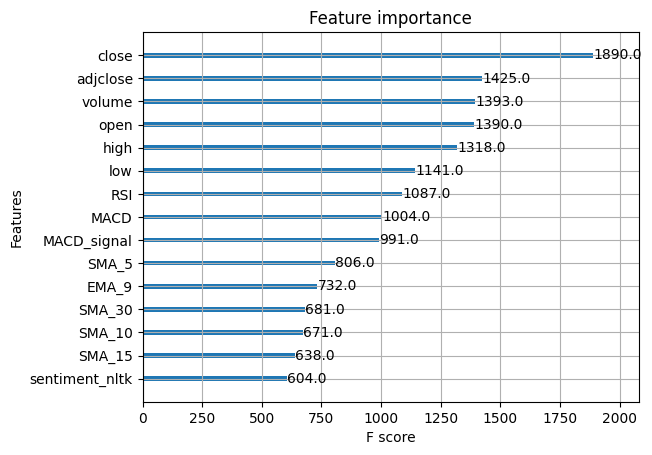

Best params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'random_state': 42, 'subsample': 0.8}
Best validation score = -0.4592734709396543
0.487684303079095


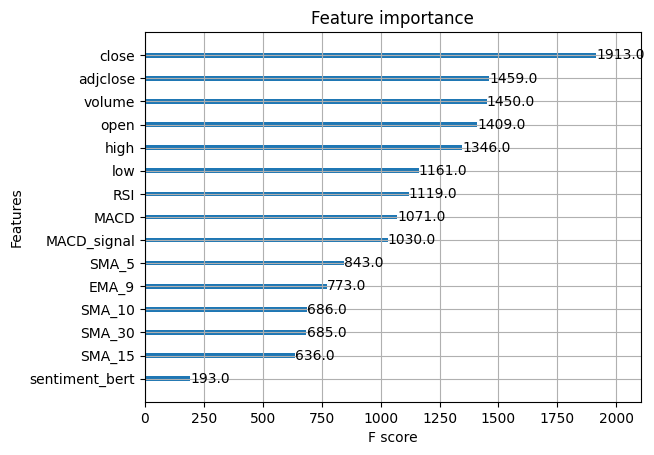

Best params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'random_state': 42, 'subsample': 0.8}
Best validation score = -0.47255550728265305
0.4606133797683623


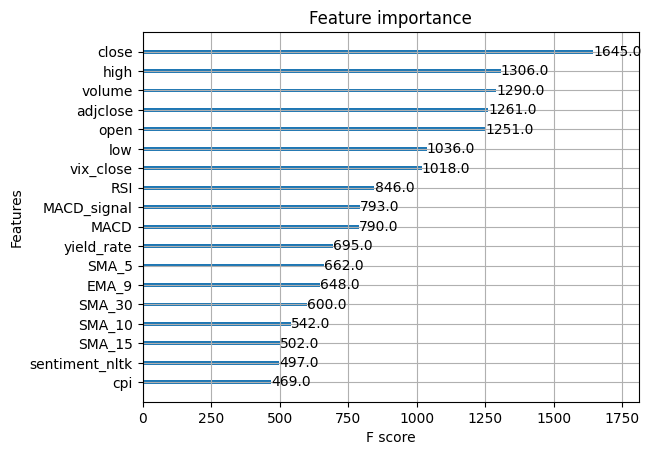

Best params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'random_state': 42, 'subsample': 0.8}
Best validation score = -0.47211907726096947
0.45888105904756044


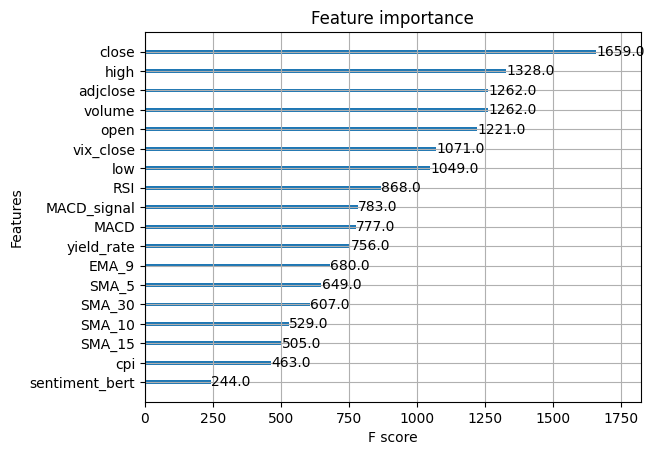

In [10]:
filenames = ["./data/set1.csv", "./data/set2.csv", "./data/set2.csv", "./data/set3.csv", "./data/set3.csv"]

found = False
for i, filename in enumerate(filenames):

    df = pd.read_csv(filename)

    df = preprocess(df)
    df = add_technical(df)
    y = df.reset_index()['target']  # Target variable
    if i:
        if i % 2:
            X = df.drop(columns=['target', 'date', "sentiment_bert"])
        else:
            X = df.drop(columns=['target', 'date', "sentiment_nltk"])
    else:
        X = df.drop(columns=['target', 'date'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if not found:
        parameters = {
        'n_estimators': [400,700],
        'learning_rate': [0.01],
        'max_depth': [5],
        'gamma': [ 0.01],
        'random_state': [42],
        'min_child_weight':[1, 5],
        'subsample':[0.8, 1],
        'colsample_bytree':[0.8],
        'colsample_bylevel':[0.8]
        }
        kfold=KFold(5)
        eval_set = [(X_train, y_train)]
        model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
        clf = GridSearchCV(model, parameters,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)

        clf.fit(X_train, y_train)

        print(f'Best params: {clf.best_params_}')
        print(f'Best validation score = {clf.best_score_}')
        found = True
    model = XGBRegressor(**clf.best_params_, objective='reg:squarederror',n_jobs=-1)

    # model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
    model.fit(X_train, y_train, verbose=False)
    y_pred=model.predict(X_test)
    loss = mean_squared_error(y_test,y_pred)
    print(loss)
    plot_importance(model)
    plt.show()

    y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['pred'])
    merged_df = pd.concat([y_test, y_pred_df], axis=1)

    write_visual_csv(i, loss)
    found = False

# XGBoost Model


In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y_test
plt.plot(merged_df.index, merged_df['target'], label='Actual', color='blue')

# Plot y_pred
plt.plot(merged_df.index, merged_df['pred'], label='Predicted', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()

# Display the plot
plt.show()